In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from shapely.geometry import Point

In [2]:
import geopandas as gpd
from shapely.wkt import loads
gdf = pd.read_csv('Borough_Boundaries_20250608.csv')
gdf['geometry'] = gdf['the_geom'].apply(loads)
gdf = gpd.GeoDataFrame(gdf[['BoroCode', 'BoroName', 'Shape_Area', 'Shape_Length', 'geometry']], geometry='geometry')

In [3]:
def load_data(csv_name: str, parse_column: list):
    return pd.read_csv(csv_name, parse_dates=parse_column)

def haversine_distance(row):
    R = 6371.0
    lat1 = np.radians(row['pickup_latitude'])
    lon1 = np.radians(row['pickup_longitude'])
    lat2 = np.radians(row['dropoff_latitude'])
    lon2 = np.radians(row['dropoff_longitude'])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

def df_for_predict(df):
    df = df.set_index('key')
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['distance_km'] = df.apply(haversine_distance, axis=1)
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
    df['month'] = df['pickup_datetime'].dt.month
    df['pickup_point'] = df.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
    df['dropoff_point'] = df.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)
    df['PickupArea'] = df['pickup_point'].apply(lambda pt: gdf.loc[gdf.contains(pt), 'BoroCode'].values[0] if gdf.contains(pt).any() else 0)
    df['DropoffArea'] = df['dropoff_point'].apply(lambda pt: gdf.loc[gdf.contains(pt), 'BoroCode'].values[0] if gdf.contains(pt).any() else 0)
    hours = df['hour']
    df['hour_sin'] = np.sin(2 * np.pi * hours / 24)
    df['hour_cos'] = np.cos(2 * np.pi * hours / 24)
    days = df['day_of_week']
    df['day_sin'] = np.sin(2 * np.pi * days / 7)
    df['day_cos'] = np.cos(2 * np.pi * days / 7)
    days = df['month']
    df['month_sin'] = np.sin(2 * np.pi * days / 7)
    df['month_cos'] = np.cos(2 * np.pi * days / 7)
    df = df.drop(['pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                  'pickup_datetime', 'pickup_point',
                 'dropoff_point', 'month', 'day_of_week', 'hour'], axis=1)
    return df

def predict_and_save_predict(df, model):
    predic = pd.DataFrame(model.best_estimator_.predict(df), columns=['fare_amount'], index=df.index)
    best_model_name = model.best_estimator_.__class__.__name__
    predic.to_csv(f'{best_model_name}_pred.csv')
    print(f'Модель сохранена под именем: {best_model_name}_pred.csv')
    return predic

In [5]:
df = load_data('df_valid_trips.csv', ['key', 'pickup_datetime'])
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'pickup_point', 'dropoff_point',
       'pickup_within', 'dropoff_within', 'distance_km', 'hour', 'day_of_week',
       'month'],
      dtype='object')

In [9]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
from shapely.geometry import Point
df['pickup_point'] = df.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
df['dropoff_point'] = df.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)
df['PickupArea'] = df['pickup_point'].apply(lambda pt: gdf.loc[gdf.contains(pt), 'BoroCode'].values[0] if gdf.contains(pt).any() else 0)
df['DropoffArea'] = df['dropoff_point'].apply(lambda pt: gdf.loc[gdf.contains(pt), 'BoroCode'].values[0] if gdf.contains(pt).any() else 0)
df = df.drop(['pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                  'pickup_datetime', 'pickup_point',
                 'dropoff_point'], axis=1)

In [13]:
df.to_csv('df_chistiy.csv')

In [4]:
df = pd.read_csv('df_chistiy.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5331791 entries, 0 to 5331790
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   key              object 
 2   fare_amount      float64
 3   passenger_count  int64  
 4   pickup_within    bool   
 5   dropoff_within   bool   
 6   distance_km      float64
 7   hour             int64  
 8   day_of_week      int64  
 9   month            int64  
 10  PickupArea       int64  
 11  DropoffArea      int64  
dtypes: bool(2), float64(2), int64(7), object(1)
memory usage: 417.0+ MB


In [5]:
hours = df['hour']
df['hour_sin'] = np.sin(2 * np.pi * hours / 24)
df['hour_cos'] = np.cos(2 * np.pi * hours / 24)
days = df['day_of_week']
df['day_sin'] = np.sin(2 * np.pi * days / 7)
df['day_cos'] = np.cos(2 * np.pi * days / 7)
days = df['month']
df['month_sin'] = np.sin(2 * np.pi * days / 7)
df['month_cos'] = np.cos(2 * np.pi * days / 7)

In [6]:
df = df.drop(['month', 'day_of_week', 'hour'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5331791 entries, 0 to 5331790
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   key              object 
 2   fare_amount      float64
 3   passenger_count  int64  
 4   pickup_within    bool   
 5   dropoff_within   bool   
 6   distance_km      float64
 7   PickupArea       int64  
 8   DropoffArea      int64  
 9   hour_sin         float64
 10  hour_cos         float64
 11  day_sin          float64
 12  day_cos          float64
 13  month_sin        float64
 14  month_cos        float64
dtypes: bool(2), float64(8), int64(4), object(1)
memory usage: 539.0+ MB


In [7]:
df = df.drop(['pickup_within', 'dropoff_within'], axis=1)

In [8]:
df = df.drop('key', axis=1)

In [9]:
df = df.drop('Unnamed: 0', axis=1)

<Axes: >

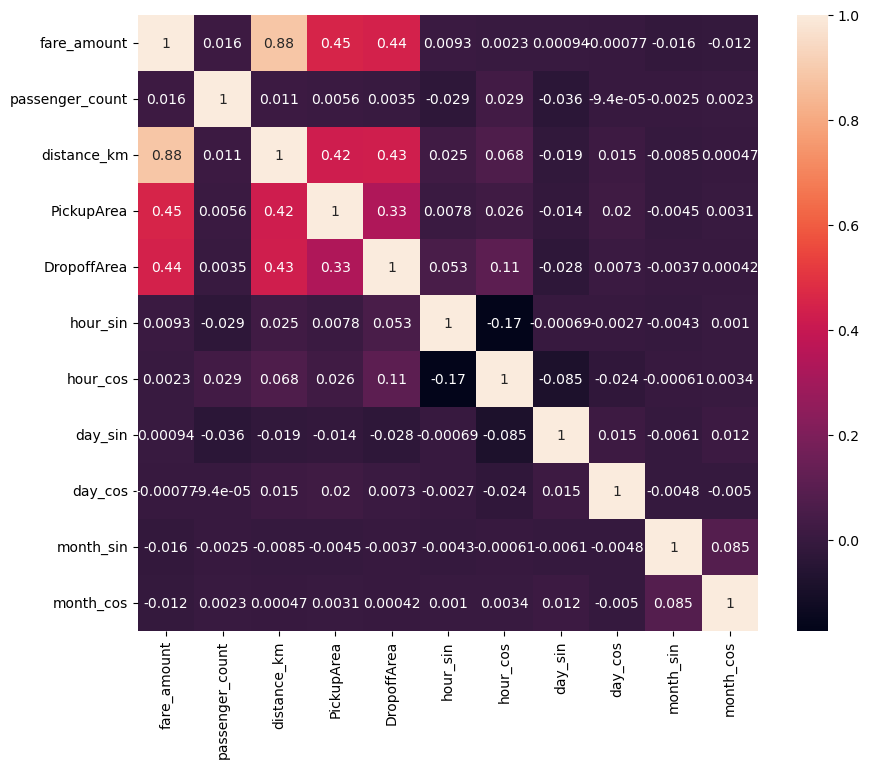

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [11]:
df_sample = df.sample(frac=0.1)
y = df_sample['fare_amount']
X = df_sample.drop('fare_amount', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('elastic_net', ElasticNet(random_state=42))])
param_grid = {
    'elastic_net__alpha': [0.01, 0.1, 1, 10],
    'elastic_net__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0] 
}
grid_model = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', refit=True)
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('elastic_net',
                                        ElasticNet(random_state=42))]),
             param_grid={'elastic_net__alpha': [0.01, 0.1, 1, 10],
                         'elastic_net__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [28]:
y_pred = grid_model.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
rmse, r2


(4.105238326612285, 0.7911908530006333)

In [22]:
test_df = pd.read_csv('test.csv')
test_df = df_for_predict(test_df)
test_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9914 entries, 2015-01-27 13:08:24.0000002 to 2015-01-18 14:06:23.0000006
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  9914 non-null   int64  
 1   distance_km      9914 non-null   float64
 2   PickupArea       9914 non-null   int64  
 3   DropoffArea      9914 non-null   int64  
 4   hour_sin         9914 non-null   float64
 5   hour_cos         9914 non-null   float64
 6   day_sin          9914 non-null   float64
 7   day_cos          9914 non-null   float64
 8   month_sin        9914 non-null   float64
 9   month_cos        9914 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 852.0+ KB


In [42]:
test_predic= predict_and_save_predict(test_df, grid_model)

Модель сохранена под именем: Pipeline_pred.csv


In [12]:
pipe_dt = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=42))
param_grid_dt = {
    'decisiontreeregressor__max_depth': [5, 10, 15],
    'decisiontreeregressor__min_samples_leaf': [1, 5, 10],
}
grid_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error')
grid_dt.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'decisiontreeregressor__max_depth': [5, 10, 15],
                         'decisiontreeregressor__min_samples_leaf': [1, 5, 10]},
             scoring='neg_mean_squared_error')

In [30]:
y_dt = grid_dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_dt))
r2_dt = r2_score(y_test, y_dt)
rmse_dt, r2_dt


(3.8545365222097483, 0.8159155519764812)

In [43]:
test_predic= predict_and_save_predict(test_df, grid_dt)

Модель сохранена под именем: Pipeline_pred.csv


In [31]:
from sklearn.ensemble import RandomForestRegressor

pipe_rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
param_grid_rf = {
    'randomforestregressor__n_estimators': [50, 100],
    'randomforestregressor__max_depth': [10],
    'randomforestregressor__min_samples_leaf': [5],
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_rf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [10],
                         'randomforestregressor__min_samples_leaf': [5],
                         'randomforestregressor__n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [32]:
y_rf = grid_rf.predict(X_test)
rmse_rf =  np.sqrt(mean_squared_error(y_test, y_rf))
r2_rf = r2_score(y_test, y_rf)
rmse_rf, r2_rf

(3.6120838182571657, 0.8389305350579601)

In [33]:
test_predic= predict_and_save_predict(test_df, grid_rf)

Модель сохранена под именем: Pipeline_pred.csv


In [34]:
from sklearn.ensemble import GradientBoostingRegressor
pipe_gbr = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=42))
param_grid_gbr = {
    'gradientboostingregressor__learning_rate': [0.01, 0.1],
    'gradientboostingregressor__n_estimators': [50, 100],
    'gradientboostingregressor__max_depth': [3, 5],
}
grid_gbr = GridSearchCV(pipe_gbr, param_grid_gbr, cv=5, scoring='neg_mean_squared_error')
grid_gbr.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.01,
                                                                      0.1],
                         'gradientboostingregressor__max_depth': [3, 5],
                         'gradientboostingregressor__n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [35]:
y_gbr = grid_gbr.predict(X_test)
rmse_gbr =  np.sqrt(mean_squared_error(y_test, y_gbr))
r2_gbr = r2_score(y_test, y_gbr)
rmse_gbr, r2_gbr

(3.601270049566368, 0.8398935031358313)

In [38]:
test_predic= predict_and_save_predict(test_df, grid_gbr)

Модель сохранена под именем: Pipeline_pred.csv


In [40]:
import xgboost as xgb
pipe_xgb = make_pipeline(StandardScaler(), xgb.XGBRegressor(random_state=42))
param_grid_xgb = {
    'xgbregressor__n_estimators': [50, 500, 700],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1],
    'xgbregressor__max_depth': [3, 5, 7, 9],
    'xgbregressor__gamma': [0, 0.1, 0.5],
    'xgbregressor__subsample': [0.5, 0.75]
}
grid_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_xgb.fit(X_train, y_train)
y_xgb = grid_xgb.predict(X_test)
rmse_xgb =  np.sqrt(mean_squared_error(y_test, y_xgb))
r2_xgb = r2_score(y_test, y_xgb)
rmse_xgb, r2_xgb

(3.6392401914886725, 0.8364995255530492)

In [41]:
test_predic= predict_and_save_predict(test_df, grid_xgb)

Модель сохранена под именем: Pipeline_pred.csv


In [36]:
from sklearn.neighbors import KNeighborsRegressor
pipe_knn = make_pipeline(StandardScaler(), KNeighborsRegressor())
param_grid_knn = {
    'kneighborsregressor__n_neighbors': [3, 5, 10, 15],
    'kneighborsregressor__weights': ['uniform', 'distance'],
}

In [37]:
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error')
grid_knn.fit(X_train, y_train)
y_knn = grid_knn.predict(X_test)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_knn))
r2_knn = r2_score(y_test, y_knn)
rmse_knn, r2_knn

(3.8582461892993716, 0.816228801049118)

In [39]:
test_predic= predict_and_save_predict(test_df, grid_knn)

Модель сохранена под именем: Pipeline_pred.csv


In [ ]:
for i in [grid_model, grid_dt, grid_rf, grid_gbr, grid_xgb, grid_knn]: 
    print(f'Лучшая модель: {i.best_estimator_}')